\begin{center} 
Chun-Yuan (Scott) Chiu 
\end{center}

\begin{center} 
chunyuac@andrew.cmu.edu 
\end{center} 

# 1. {-}

## (a) {-}

In [2]:
# contents of problem1.py

import numpy as np

def get_data(n):
#     np.random.seed(0)               # fix seed
    x = np.random.uniform(size=n)
    y = x**2-x/2.0 + np.random.normal(size=n,scale=0.1)
    idx = np.argsort(x)
    return(x[idx].reshape((-1,1)),y[idx].reshape((-1,1)))

def true_mean(x):
    return(x**2-x/2.0)


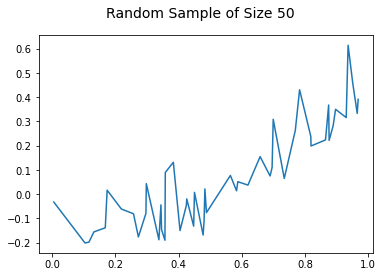

In [3]:
import matplotlib.pyplot as plt

X_train, y_train = get_data(50)
plt.plot(X_train, y_train)
plt.suptitle('Random Sample of Size 50', fontsize=14)
plt.show()

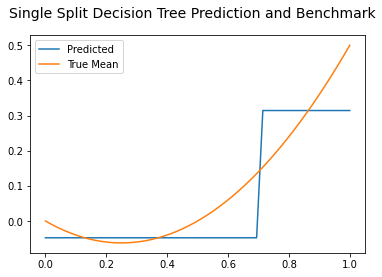

In [4]:
from sklearn.tree import DecisionTreeRegressor
from pandas import DataFrame

tree = DecisionTreeRegressor(max_depth=1).fit(X_train, y_train)
xgrid = np.array(np.linspace(0, 1, num=50)).reshape(50, 1)
df = DataFrame({'Predicted': tree.predict(xgrid), 'True Mean': true_mean(xgrid).flatten()}, index=xgrid.flatten())
df.plot()
plt.suptitle('Single Split Decision Tree Prediction and Benchmark', fontsize=14)
plt.show()

## (b) {-}

We define a function that plots the trees, the average, the benchmark (true mean), the bias and variance. 

In [10]:
def tree1d(suptitle, n_sim=100, **DTkwarg):
    xgrid = np.array(np.linspace(0, 1, num=50)).reshape(50, 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))
    fig.suptitle(suptitle, fontsize=16)
    
    pred = []
    for i in range(n_sim):
        X_train, y_train = get_data(50)
        tree = DecisionTreeRegressor(**DTkwarg).fit(X_train, y_train)
        pred_this_run = tree.predict(xgrid)
        pred.append(pred_this_run)
        ax1.plot(xgrid, pred_this_run, label=None)
    
    pred = np.array(pred)
    pred_mean = pred.mean(axis=0)
    true = true_mean(xgrid).flatten()

    ax1.plot(xgrid, true, 'b', linewidth=4, label='True Mean')
    ax1.plot(xgrid, pred_mean, 'r', linewidth=4, label='Average of All Trees')
    ax1.set(title='Trees, Their Average and the Benchmark')
    ax1.legend()

    ax2.plot(xgrid, pred_mean - true, label='Bias')
    ax2.plot(xgrid, pred.var(axis=0), label='Variance')
    ax2.set(title='Bias and Variance')
    ax2.legend()

    plt.subplots_adjust(top=0.85)
    plt.show()

Below are the plots on single-split trees. On the left and on the right the average (the red thick line) is flat just like a step function, but in the middle where all the simulation splits happens, since the average is allowed to be a curve, it is a much better approximation of the true mean (the blue thick line) than step functions. 

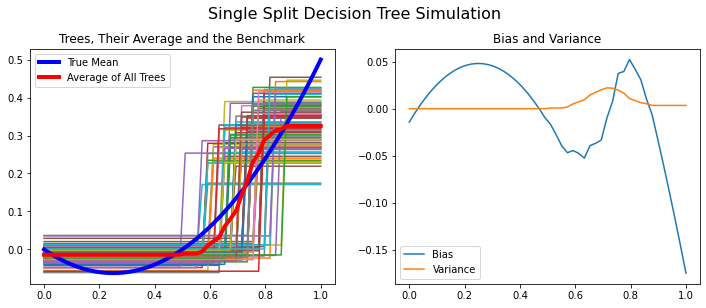

In [16]:
tree1d(suptitle='Single Split Decision Tree Simulation', max_depth=1)

## (c) {-}

When 5 splits are allowed, the average is an even better approximation to the true mean than the average of single-split trees, but the individual trees seems to be more spread out than the single-split trees. This can also be seen from the bias and variance plots. The variance of single-split trees is quite close to 0 except in the neighborhood of $x=0.7$, while the trees with 5 splits have slightly larger variance except in the same neighborhood. 

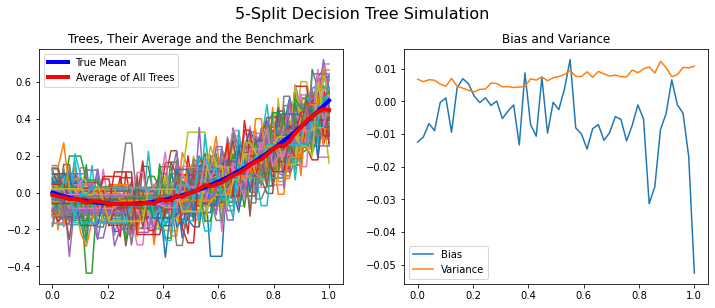

In [15]:
# tree1d(suptitle='5-Split Decision Tree Simulation', max_leaf_nodes=6)
tree1d(suptitle='5-Split Decision Tree Simulation', max_depth=5)

# 2. {-}

## (a)(b)(c) {-}

First we split the data to form training and test sets. 

In [8]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

X = pd.read_csv('marketing.csv')
X = pd.get_dummies(X, columns=['job', 'marital', 'education', 'default', 'housing', 'loan'])
y = np.where(X.pop('y')=='yes', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

We train 4 models: the logistic regression, a random forest of 500 trees with scikit-learn default, a random forest of 500 trees with ```min_samples_leaf = 10``` (this will make the tree shorter), and a random forest of 500 trees with ```min_samples_leaf = 10``` and ```class_weight='balanced'```. The training takes quite some time so we serialize the models after training, compress and save locally. 

Without compression the serialized default random forest is 300 MB and will need Git LFS to upload to GitHub. Various ways to compress a file are discussed in [here](https://stackoverflow.com/questions/57983431/whats-the-most-space-efficient-way-to-compress-serialized-python-data). 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pickle, lzma

lr = LogisticRegression(penalty='none')
rf = RandomForestClassifier(n_estimators=500, oob_score=True)
rfsmall = RandomForestClassifier(n_estimators=500, oob_score=True, min_samples_leaf=10)
rfbalance = RandomForestClassifier(n_estimators=500, oob_score=True, min_samples_leaf=10, class_weight='balanced')

for i, clf in enumerate([lr, rf, rfsmall, rfbalance]):
    fitted = clf.fit(X_train, y_train)
    with lzma.open(f'clf{i}.xz', 'wb') as f:
        f.write(pickle.dumps(fitted))

In [9]:
import lzma, pickle

with lzma.open('clf0.xz', 'rb') as f:
    lr = pickle.loads(f.read())

with lzma.open('clf1.xz', 'rb') as f:
    rf = pickle.loads(f.read())    

with lzma.open('clf2.xz', 'rb') as f:
    rfsmall = pickle.loads(f.read())    
    
with lzma.open('clf3.xz', 'rb') as f:
    rfbalance = pickle.loads(f.read())    

model = {'Logistic Regression': lr, 'RF': rf, 'RF Small': rfsmall, 'RF Balanced': rfbalance}
model

{'Logistic Regression': LogisticRegression(penalty='none'),
 'RF': RandomForestClassifier(n_estimators=500, oob_score=True),
 'RF Small': RandomForestClassifier(min_samples_leaf=10, n_estimators=500, oob_score=True),
 'RF Balanced': RandomForestClassifier(class_weight='balanced', min_samples_leaf=10,
                        n_estimators=500, oob_score=True)}

Below is a summary of the metrics on all 4 models. We have printed out the model names and the corresponding settings in the above dictionary. For random forests, the OOB error seems to be a good approximation of the misclassification rate. Setting ```min_samples_leaf``` to 10 does improve the AUC but the hit rate in the top 1000 people drops. We further set ```class_weight``` to ```'balanced'``` and the improvement in AUC is tiny. The misclassification rate greatly improved which we will discuss later. In any cases, random forests always outperform the logistic regression. 

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, auc, confusion_matrix, roc_curve
from pandas import DataFrame

y_pred = np.zeros_like(y_test)
print('Base Rate: ', 1 - accuracy_score(y_test, y_pred))

res = {} 
for modelname, clf in model.items():
    y_pred = clf.predict(X_test)
    predict_proba_test = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, predict_proba_test) 
    
    bestIdxSet = predict_proba_test.argsort()[-1000:]
    y_select = y_test[bestIdxSet]
    
    res[modelname] = {
        'Misclassification Rate': 1 - accuracy_score(y_test, y_pred), 
        'OOB Error': 1 - clf.oob_score_ if 'RF' in modelname else None, 
        'Hit Rate in Top 1000': y_select.sum()/len(y_select), 
        'AUC': auc(fpr, tpr), 
#         'Confusion Matrix': confusion_matrix(y_test, y_pred), 
    }
    
DataFrame(res)

Base Rate:  0.11528150134048254


,Logistic Regression,RF,RF Small,RF Balanced
Misclassification Rate,0.115483,0.125201,0.115885,0.229960
OOB Error,NaN,0.128652,0.117725,0.235648
Hit Rate in Top 1000,0.291000,0.432000,0.383000,0.384000
AUC,0.664587,0.681964,0.709595,0.709954


Below are the ROC curves. RF Small and RF Balanced are quite similar. The default random forest is the best if one wants the model to be very specific and does not need it to be sensitive. Again, the logistic regression has a the worst prediction. 

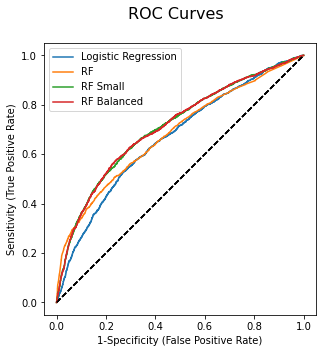

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for name, clf in model.items():
    predict_proba_test = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, predict_proba_test) 
    ax.plot(fpr, tpr, label=name)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set( aspect=1, 
            xlabel='1-Specificity (False Positive Rate)', 
            ylabel='Sensitivity (True Positive Rate)')
    
fig.suptitle('ROC Curves', fontsize=16)
plt.legend()
plt.show()

Now we investigate the misclassification rate change after setting ```class_weight``` to ```'balanced'```. First we define a function that reports the confusion matrix and the misclassification rate. 

In [12]:
def report_confusion(clf, threshold):
    y_pred = clf.predict(X_test)
    predict_proba_test = clf.predict_proba(X_test)[:, 1]
    estimate = predict_proba_test > threshold

    tp = (y_test & estimate).sum()
    fp = ((1-y_test) & estimate).sum()
    fn = (y_test & (1-estimate)).sum()
    tn = ((1-y_test) & (1-estimate)).sum()

    print('Misclassification Rate: ', (fp + fn)/(tp + fp + fn + tn), '\n')
    return DataFrame([[tp, fp], [fn, tn]], columns=['True 1', 'True 0'], index=['Guess 1', 'Guess 0'])

We print out the results for RF Small and RF Balanced. At first glance the improved misclassification rate from setting ```class_weight='balanced'``` seems mysterious, especially given how close their ROC curves are. But we then print out the results for RF Small with threshold 0.15 and get a very similar confusion matrix and misclassification rate to RF Balanced. Looks like in this case the argument ```class_weight``` changes the shape of the prediction function by moving down the RF Small predicted probabilities from 0.5 to 0.15, but it does not change the decision boundary. 

In [15]:
print('RF Balanced: \n')
report_confusion(rfbalance, threshold=0.5)

RF Balanced: 

Misclassification Rate:  0.2299597855227882 



,True 1,True 0
Guess 1,890,2601
Guess 0,830,10599


In [7]:
print('RF Small: \n')
report_confusion(rfsmall, threshold=0.5)

Misclassification Rate:  0.11588471849865951 



,True 1,True 0
Guess 1,11,20
Guess 0,1709,13180


In [16]:
print('RF Small with Threshold 0.15: \n')
report_confusion(rfsmall, threshold=0.15)

RF Small with Threshold 0.15: 

Misclassification Rate:  0.22861930294906166 



,True 1,True 0
Guess 1,880,2571
Guess 0,840,10629


# 3. {-}

## (a) {-}

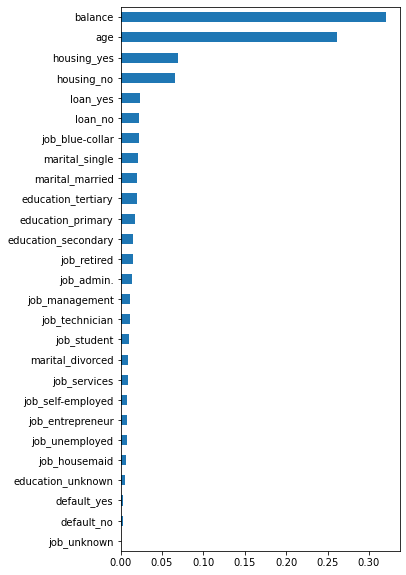

In [30]:
DataFrame({'Importance': rfbalance.feature_importances_}, index=X.columns)\
            .sort_values(by='Importance')\
            .plot(kind='barh', legend=None, figsize=(5, 10))
plt.show()

## (b) {-}

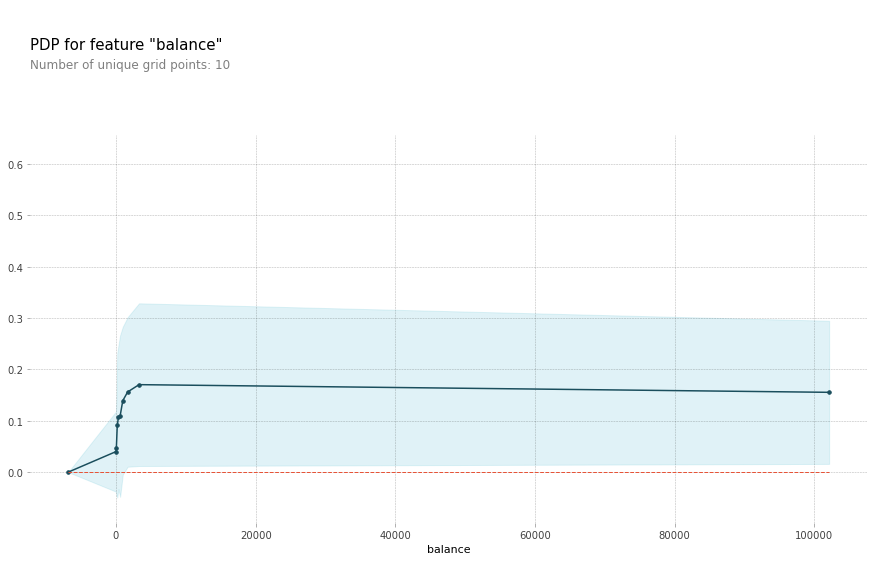

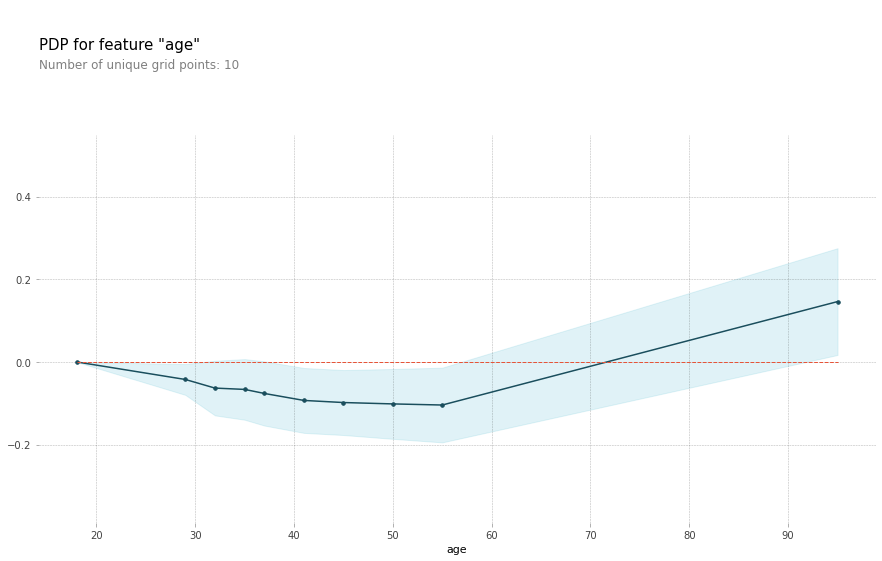

In [43]:
from pdpbox import pdp

pdp_obj = pdp.pdp_isolate(model=rfbalance, dataset=X_train, model_features=X_train.columns, feature='balance')
fig, ax = pdp.pdp_plot(pdp_obj, 'balance')

pdp_obj = pdp.pdp_isolate(model=rfbalance, dataset=X_train, model_features=X_train.columns, feature='age')
fig, ax = pdp.pdp_plot(pdp_obj, 'age')

# 4. {-}

## (a) {-}

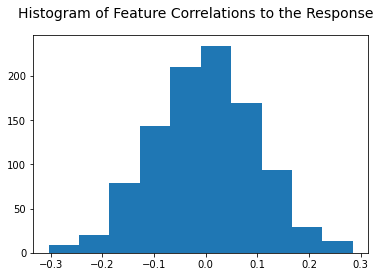

In [1]:
from scipy.stats import norm, pearsonr
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)

def get_data(n):
    p = 1000
    X = norm().rvs(n*p).reshape((n,p))
    y = norm().rvs(n)
    return X, y

n = 100
X, y = get_data(n)

corrs = np.apply_along_axis(lambda x: pearsonr(x, y)[0], 0, X)
plt.hist(corrs)
plt.suptitle('Histogram of Feature Correlations to the Response', fontsize=14)
plt.show()

## (b) {-}

In [3]:
columns_good = (abs(corrs) > 0.2)

X_good = X[:, columns_good]

X_good.shape

(100, 42)

## (c) {-}

The cross-validated MSE is 0.579, while the MSE on the test data is 0.417. 

In [5]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

X_train = X_good[:round(n*0.8), :]
y_train = y[:round(n*0.8)]

X_test = X_good[-round(n*0.2):, :]
y_test = y[-round(n*0.2):]

model = LassoCV().fit(X_train, y_train)

print('CV-MSE:           ', model.mse_path_.mean(axis=1).min())
print('MSE on Test Data: ', mean_squared_error(y_test, model.predict(X_test)))

CV-MSE:            0.5794562579855869
MSE on Test Data:  0.41681392483613744


## (d) {-}

The MSE on the new data is 1.456. 

Initially we have 1000 features, out of which we selected 42 that are the most correlated to the response. This selection process makes the features artificially good. Naturally the cross-validated MSE and the MSE on the test data will not be too far off. 

Imagine an extreme case where we have a million features or even more. Just because there are so many, chances are we will get one that is highly correlated to the response in sample. When we split the observations from this feature to form training and test sets, that test data as part of the original sample is still highly correlated to the response. This all makes this feature seem a pretty good predictor, while we know the underlying truth is they are just independent noise. 

But once we go out of sample, like we do below, the new observations will be like any other independent features and will not do any good in predicting the response. 

In [4]:
X, y = get_data(n)

X_good = X[:, columns_good]

mean_squared_error(y, model.predict(X_good))

1.4559170661813172